# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=5,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-46-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5023 | MulticlassF1Score=0.1566
Batch-30 : CrossEntropyLoss=2.4719 | MulticlassF1Score=0.2096
Batch-45 : CrossEntropyLoss=2.4376 | MulticlassF1Score=0.2544
Batch-60 : CrossEntropyLoss=2.4423 | MulticlassF1Score=0.2927
Batch-75 : CrossEntropyLoss=2.3897 | MulticlassF1Score=0.3413
Batch-90 : CrossEntropyLoss=2.3668 | MulticlassF1Score=0.3809
Batch-105: CrossEntropyLoss=2.3853 | MulticlassF1Score=0.4091
Batch-120: CrossEntropyLoss=2.3684 | MulticlassF1Score=0.4318
Batch-135: CrossEntropyLoss=2.3997 | MulticlassF1Score=0.4499
Batch-150: CrossEntropyLoss=2.3701 | MulticlassF1Score=0.4640
Batch-165: CrossEntropyLoss=2.3573 | MulticlassF1Score=0.4755
Batch-180: CrossEntropyLoss=2.3853 | MulticlassF1Score=0.4851
Batch-195: CrossEntropyLoss=2.3947 | MulticlassF1Score=0.4930
Batch-210: CrossEntropyLoss=2.3570 | MulticlassF1Score=0.5034
Batch-225: CrossEntropyLoss=2.3464 | MulticlassF1Score=0.5169
Batch-226: CrossEntropyLoss=2.3262 | MulticlassF1Score=0.5174

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3299 | MulticlassF1Score=0.7151
Batch-30 : CrossEntropyLoss=2.3392 | MulticlassF1Score=0.7066
Batch-45 : CrossEntropyLoss=2.3297 | MulticlassF1Score=0.7067
Batch-60 : CrossEntropyLoss=2.3380 | MulticlassF1Score=0.7059
Batch-63 : CrossEntropyLoss=2.3544 | MulticlassF1Score=0.7067

Training   : Mean CrossEntropyLoss = 2.4089 | Mean MulticlassF1Score = 0.3783
Validation : Mean CrossEntropyLoss = 2.3420 | Mean MulticlassF1Score = 0.7088

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6966
Batch-30 : CrossEntropyLoss=2.3327 | MulticlassF1Score=0.7040
Batch-45 : CrossEntropyLoss=2.3337 | MulticlassF1Score=0.7063
Batch-60 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7156
Batch-75 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7233
Batch-90 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7305
Batch-105: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7349
Batch-120: CrossEntropyLoss=2.3207 | MulticlassF1Score=0.7405
Batch-135: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7451
Batch-150: CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7504
Batch-165: CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7538
Batch-180: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7572
Batch-195: CrossEntropyLoss=2.3216 | MulticlassF1Score=0.7598
Batch-210: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7624
Batch-225: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7643
Batch-226: CrossEntropyLoss=2.3350 | MulticlassF1Score=0.7644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7886
Batch-30 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7918
Batch-45 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.7914
Batch-60 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7908
Batch-63 : CrossEntropyLoss=2.3341 | MulticlassF1Score=0.7906

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3219 | Mean MulticlassF1Score = 0.7339
Validation : Mean CrossEntropyLoss = 2.3137 | Mean MulticlassF1Score = 0.7914

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7926
Batch-30 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.7946
Batch-45 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7943
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.7932
Batch-75 : CrossEntropyLoss=2.3232 | MulticlassF1Score=0.7927
Batch-90 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7916
Batch-105: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7917
Batch-120: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7915
Batch-135: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7920
Batch-150: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7929
Batch-165: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7927
Batch-180: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7926
Batch-195: CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7929
Batch-210: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7930
Batch-225: CrossEntropyLoss=2.3189 | MulticlassF1Score=0.7932
Batch-226: CrossEntropyLoss=2.3255 | MulticlassF1Score=0.7932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7931
Batch-30 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7930
Batch-45 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7943
Batch-60 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7940
Batch-63 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7932

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3121 | Mean MulticlassF1Score = 0.7928
Validation : Mean CrossEntropyLoss = 2.3125 | Mean MulticlassF1Score = 0.7931

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8002
Batch-30 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7987
Batch-45 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.7963
Batch-60 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7975
Batch-75 : CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7974
Batch-90 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.7970
Batch-105: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7965
Batch-120: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7958
Batch-135: CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7966
Batch-150: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.7984
Batch-165: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.7993
Batch-180: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8000
Batch-195: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8009
Batch-210: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.8008
Batch-225: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8012
Batch-226: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8012

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8099
Batch-30 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8060
Batch-45 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8061
Batch-60 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8068
Batch-63 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.8067

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3094 | Mean MulticlassF1Score = 0.7990
Validation : Mean CrossEntropyLoss = 2.3082 | Mean MulticlassF1Score = 0.8065

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8118
Batch-30 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8113
Batch-45 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8138
Batch-60 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8170
Batch-75 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8178
Batch-90 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8204
Batch-105: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8217
Batch-120: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8222
Batch-135: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8230
Batch-150: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8229
Batch-165: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8242
Batch-180: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8242
Batch-195: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8250
Batch-210: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8254
Batch-225: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8259
Batch-226: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8260

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8328
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8294
Batch-45 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8284
Batch-63 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3016 | Mean MulticlassF1Score = 0.8200
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8304

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8273
Batch-30 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8283
Batch-45 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8296
Batch-60 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8291
Batch-75 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8303
Batch-90 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8309
Batch-105: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8327
Batch-120: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8342
Batch-135: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8354
Batch-150: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8364
Batch-165: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8370
Batch-180: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8376
Batch-195: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8385
Batch-210: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8391
Batch-225: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8402
Batch-226: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8452
Batch-30 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8442
Batch-45 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8439
Batch-60 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8437
Batch-63 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2973 | Mean MulticlassF1Score = 0.8335
Validation : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8426

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8435
Batch-30 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8459
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8462
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8469
Batch-75 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8481
Batch-90 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8477
Batch-105: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8487
Batch-120: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8505
Batch-135: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8527
Batch-150: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8548
Batch-165: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8559
Batch-180: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8577
Batch-195: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8588
Batch-210: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8602
Batch-225: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8610
Batch-226: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8610

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8692
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8705
Batch-45 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8707
Batch-60 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8711
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8718

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2910 | Mean MulticlassF1Score = 0.8517
Validation : Mean CrossEntropyLoss = 2.2880 | Mean MulticlassF1Score = 0.8705

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8789
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8752
Batch-45 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8774
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8764
Batch-75 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8769
Batch-90 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8767
Batch-105: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8771
Batch-120: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8774
Batch-135: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8773
Batch-150: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8768
Batch-165: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8773
Batch-180: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8778
Batch-195: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8779
Batch-210: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8776
Batch-225: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8778
Batch-226: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8778

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8751
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8759
Batch-45 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8752
Batch-60 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8737
Batch-63 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8740

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8774
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8760

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8881
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8826
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8830
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8804
Batch-75 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8801
Batch-90 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8795
Batch-105: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8804
Batch-120: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8803
Batch-135: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8807
Batch-150: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8808
Batch-165: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8815
Batch-180: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8819
Batch-195: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8825
Batch-210: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8834
Batch-225: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8838
Batch-226: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8838

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8845
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8844
Batch-45 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8847
Batch-60 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8830
Batch-63 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8833

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2838 | Mean MulticlassF1Score = 0.8819
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8836

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8891
Batch-30 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8890
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8881
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8898
Batch-75 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8903
Batch-90 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8907
Batch-105: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8907
Batch-120: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8906
Batch-135: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8907
Batch-150: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8906
Batch-165: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8908
Batch-180: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8907
Batch-195: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8904
Batch-210: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8903
Batch-225: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8907
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8906

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8862
Batch-30 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8841
Batch-45 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8836
Batch-60 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8835
Batch-63 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8839

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8902
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8851

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9004
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8950
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8932
Batch-75 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8937
Batch-90 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8929
Batch-105: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8921
Batch-135: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8919
Batch-150: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8917
Batch-165: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8921
Batch-180: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8920
Batch-195: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8922
Batch-210: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8923
Batch-225: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8924
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8923

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8866
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8848
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8843
Batch-63 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8849

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8936
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8854

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8893
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8909
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8925
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8924
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8942
Batch-90 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8939
Batch-105: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8939
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8944
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8941
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8940
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8935
Batch-180: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8934
Batch-195: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8937
Batch-210: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8936
Batch-225: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8939
Batch-226: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8939

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8880
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8839
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8836
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8850
Batch-63 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8853

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8931
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8844

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8947
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8948
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8957
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8975
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8977
Batch-105: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8979
Batch-120: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8977
Batch-135: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8978
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8977
Batch-165: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8976
Batch-180: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8977
Batch-195: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8977
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8978
Batch-225: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8980
Batch-226: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8980

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8882
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8868
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8874
Batch-63 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8971
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8866

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8984
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9008
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9025
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9025
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9018
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9020
Batch-105: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.9013
Batch-120: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.9011
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9004
Batch-150: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9007
Batch-165: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9007
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9006
Batch-195: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9008
Batch-210: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.9005
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9006
Batch-226: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9007

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8900
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8896
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8889

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9012
Validation : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8908

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9007
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9022
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9021
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9035
Batch-75 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9034
Batch-90 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9031
Batch-105: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9021
Batch-120: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.9020
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9021
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9020
Batch-165: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9023
Batch-180: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9023
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9023
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9023
Batch-225: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9023
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9023

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8920
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8926
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8909
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8901
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8905

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9026
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8913

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9068
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9062
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9076
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9073
Batch-75 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9069
Batch-90 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.9058
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9054
Batch-120: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9051
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9045
Batch-150: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9042
Batch-165: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9042
Batch-180: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9044
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9041
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9041
Batch-225: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.9038
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9039

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8927
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8904
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8903
Batch-63 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8902

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2773 | Mean MulticlassF1Score = 0.9057
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8917

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9050
Batch-30 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9062
Batch-45 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9045
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9061
Batch-75 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9056
Batch-90 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9053
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9056
Batch-120: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9048
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9049
Batch-150: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9047
Batch-165: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9047
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9045
Batch-195: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9045
Batch-210: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.9041
Batch-225: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9043
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9044

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8908
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8907
Batch-60 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8905
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8904

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9052
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8899

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9087
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9041
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9062
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9045
Batch-75 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9039
Batch-90 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.9037
Batch-105: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9045
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9048
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9046
Batch-150: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9049
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9050
Batch-180: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9051
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9058
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9074
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9082
Batch-226: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9082

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9132
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9127
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9128
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9125

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9055
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9133

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9274
Batch-75 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9277
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9276
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9273
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9275
Batch-135: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9273
Batch-150: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9276
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9276
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9278
Batch-195: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9279
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9279
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9281
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9282

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9173
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9163
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9162

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9265
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9168

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9328
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9332
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9332
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9325
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9327
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9324
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9320
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9324
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9322
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9322
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9321
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9320
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9322
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9175
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9196

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9322
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9190

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9329
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9340
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9343
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9339
Batch-75 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9348
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9357
Batch-105: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9352
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9351
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9351
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9349
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9347
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9345
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9342
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9342

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9199

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9343
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9197

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9355
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9357
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9357
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9365
Batch-105: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9366
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9360
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9356
Batch-150: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9359
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9354
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9354
Batch-226: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9354

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9206
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9205
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9209

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9356
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9212

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9366
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9367
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9368
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9369
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9370
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9368
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9367
Batch-225: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9363
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9176
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9197
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9200

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9371
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9189

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9380
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9378
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9377
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9377
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9376
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9376
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9370
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9368
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9372
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9170
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9194
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9205
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9206

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9199

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9375
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9375
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9377
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9378
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9378
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9377
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9205

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9382
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9188

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9353
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9385
Batch-75 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9372
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9372
Batch-150: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9372
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9372
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9205

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9194
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9391
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9390
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9386
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9385
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9381
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9209

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9388
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9229

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9513
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9533
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9536
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9541
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9543
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9548
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9551
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9552
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9554
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9556
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9556
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9557
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9556
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9556

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9392
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9403
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9404

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2614 | Mean MulticlassF1Score = 0.9524
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9385

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9601
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9589
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9582
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9575
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9576
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9577
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9578
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9579
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9578
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9577
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9576
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9576
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9576
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9578
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9579
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9579

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9413
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9412

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9580
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9414

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9550
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9564
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9571
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9573
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9573
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9569
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9573
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9575
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9580
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9580
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9583
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9584
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9583
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9584
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9583
Batch-226: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9584

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9420
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9420

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9574
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9410

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9588
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9601
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9596
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9594
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9592
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9595
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9598
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9597
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9595
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9597
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9600
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9600
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9598
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9598
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9598
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9439
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9434

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9594
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9433

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9614
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9606
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9608
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9609
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9608
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9610
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9606
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9607
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9607
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9607
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9608
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9610
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9610
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9609
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9607
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9607

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9431
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9427

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2597 | Mean MulticlassF1Score = 0.9607
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9447

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9593
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9609
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9607
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9602
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9606
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9613
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9605
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9607
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9607
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9609
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9609
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9608
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9610
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9613
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9613
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9613

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9430
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9606
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9426

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9634
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9624
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9621
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9618
Batch-120: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9619
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9615
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9618
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9615
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9615
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9429
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9431

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9625
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9413

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9621
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9623
Batch-45 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9626
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9614
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9613
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9616
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9617
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9619
Batch-226: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9619

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9438

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9619
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9419

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9634
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9626
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9623
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9623
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9623
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9632
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9632
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9630
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9628
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9627
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9624
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9623
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9435

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9625
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9408

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9634
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9636
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9633
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9631
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9632
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9629
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9629
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9630
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9628
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9627
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9628
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9627
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9628

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9628
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9435

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9639
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9641
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9639
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9639
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9635
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9636
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9635
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9632
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9633
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9633
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9632
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9424
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9433
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9635
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9442

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9659
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9650
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9645
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9650
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9640
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9644
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9639
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9640
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9635
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9634
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9450

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9636
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9633
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9644
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9643
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9641
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9643
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9641
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9638
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9636
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9637
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9636

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9447

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9619
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9635
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9640
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9643
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9643
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9640
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9639
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9637

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9458

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9628
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9629
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9638
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9647
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9646
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9642
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9636
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9637
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9642
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9462

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9474

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9622
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9635
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9650
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9652
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9653
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9650
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9652
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9655
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9462

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9648
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9456

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9642
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9653
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9659
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9451

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9664
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9470

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9527
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9505

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2517 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9479

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9702
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9502
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9500
Batch-63 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9499

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9505

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9718
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9707
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9705
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9509
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9509

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2565
Best CrossEntropyLoss training    : 2.2633
Best MulticlassF1Score validation : 0.9711
Best MulticlassF1Score validation : 0.9509
Training duration                 : 2.3355 minutes.
Training date                     : 2022-10-19 13:33:27.327213+08:00


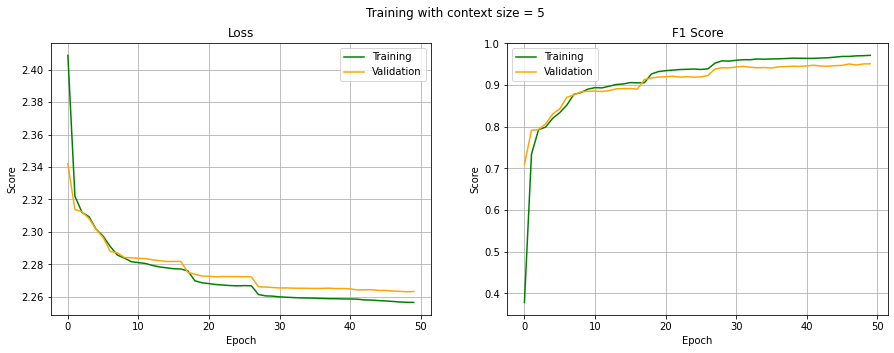

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9710, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9477, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9710, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9477, device='cuda:0'))

## Heatmap

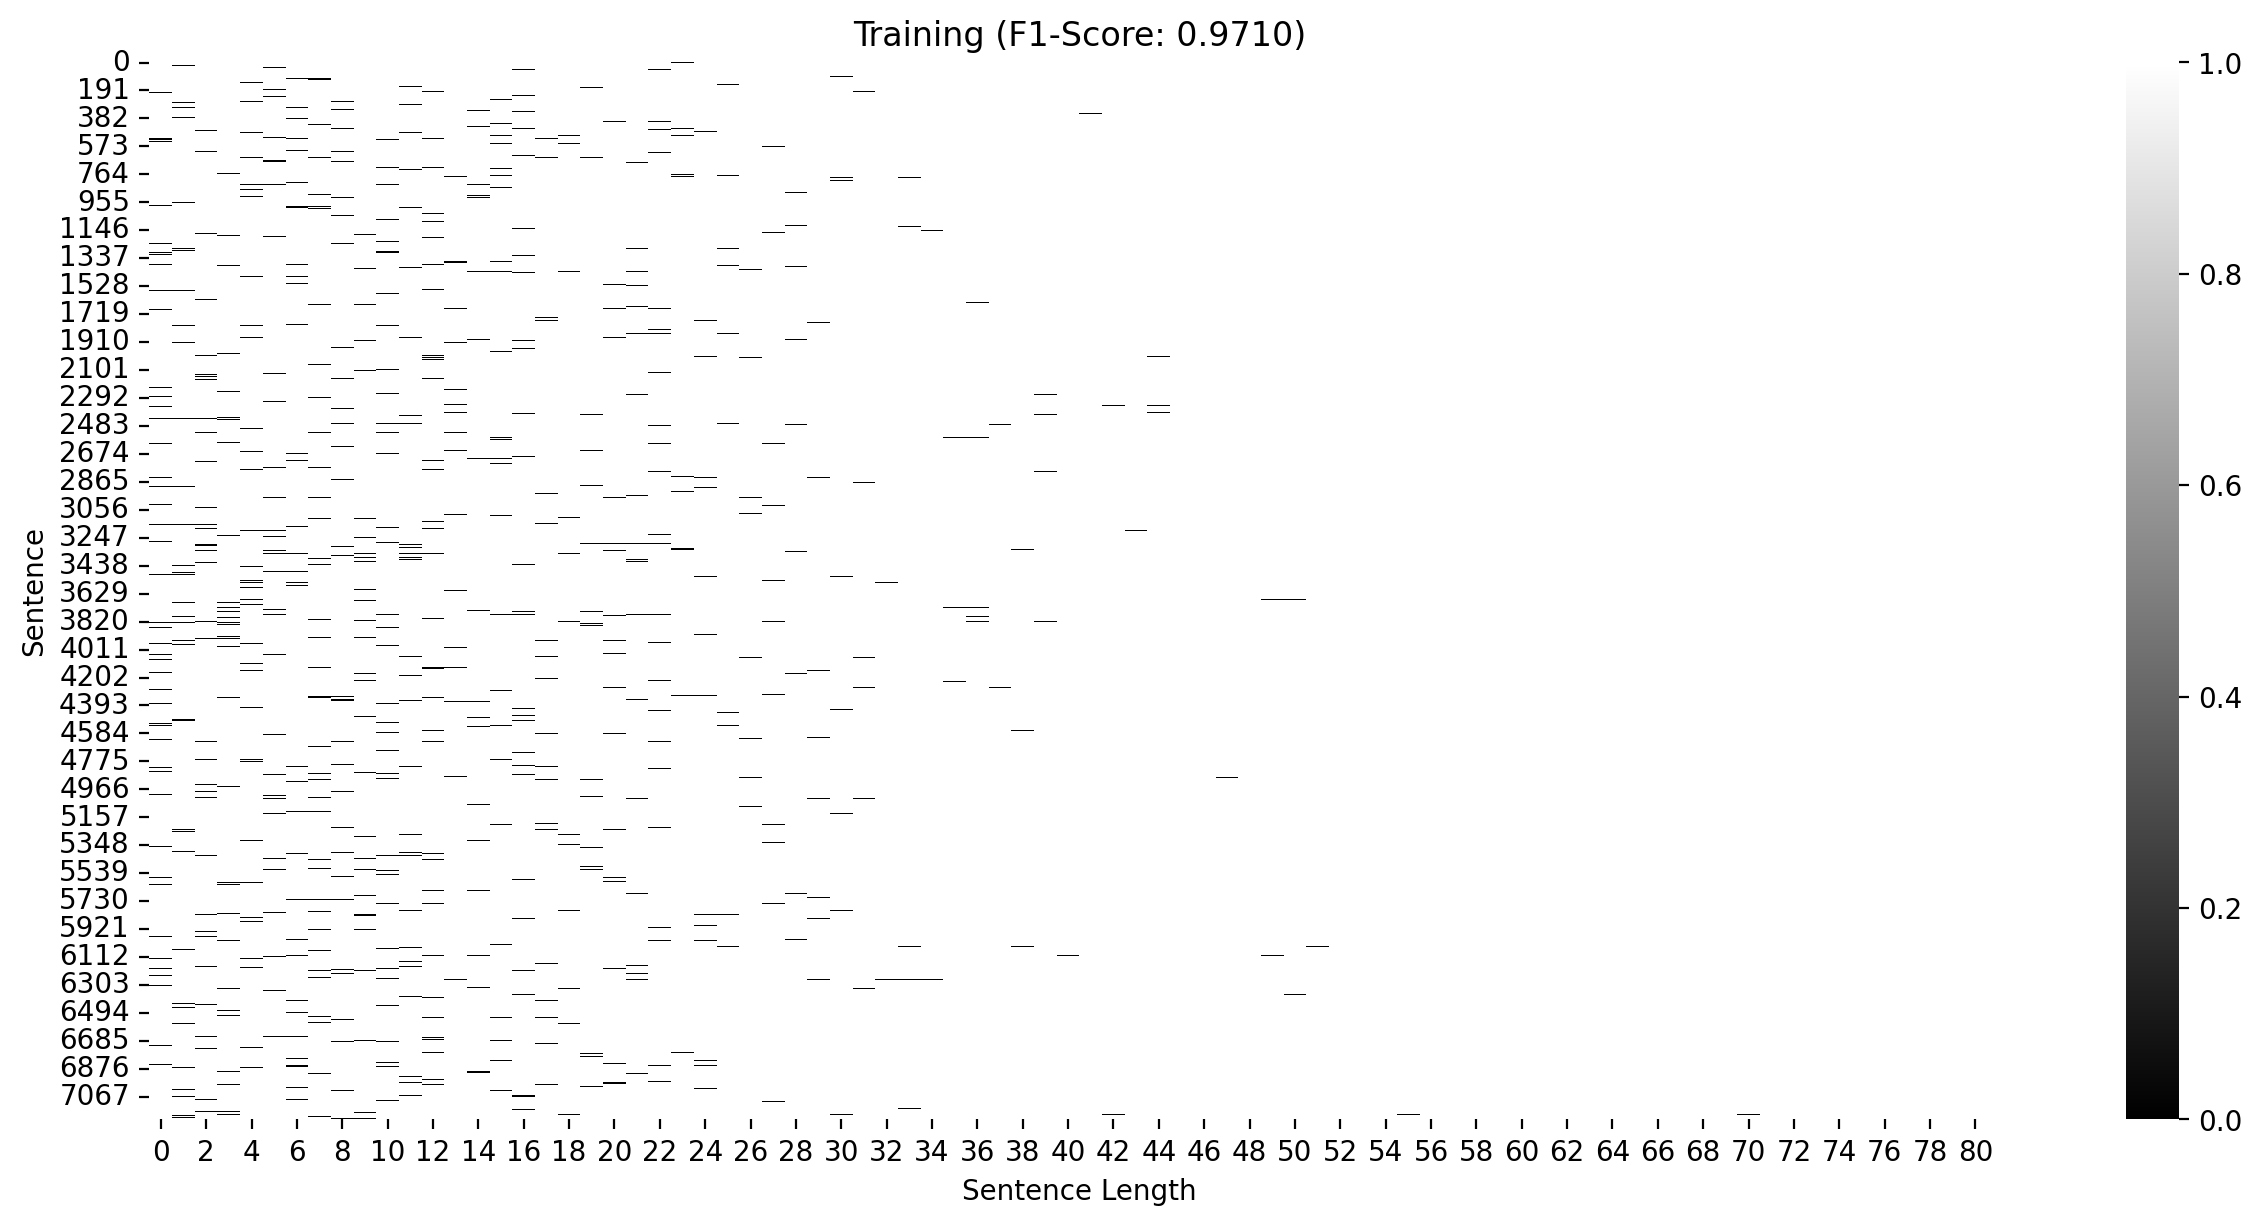

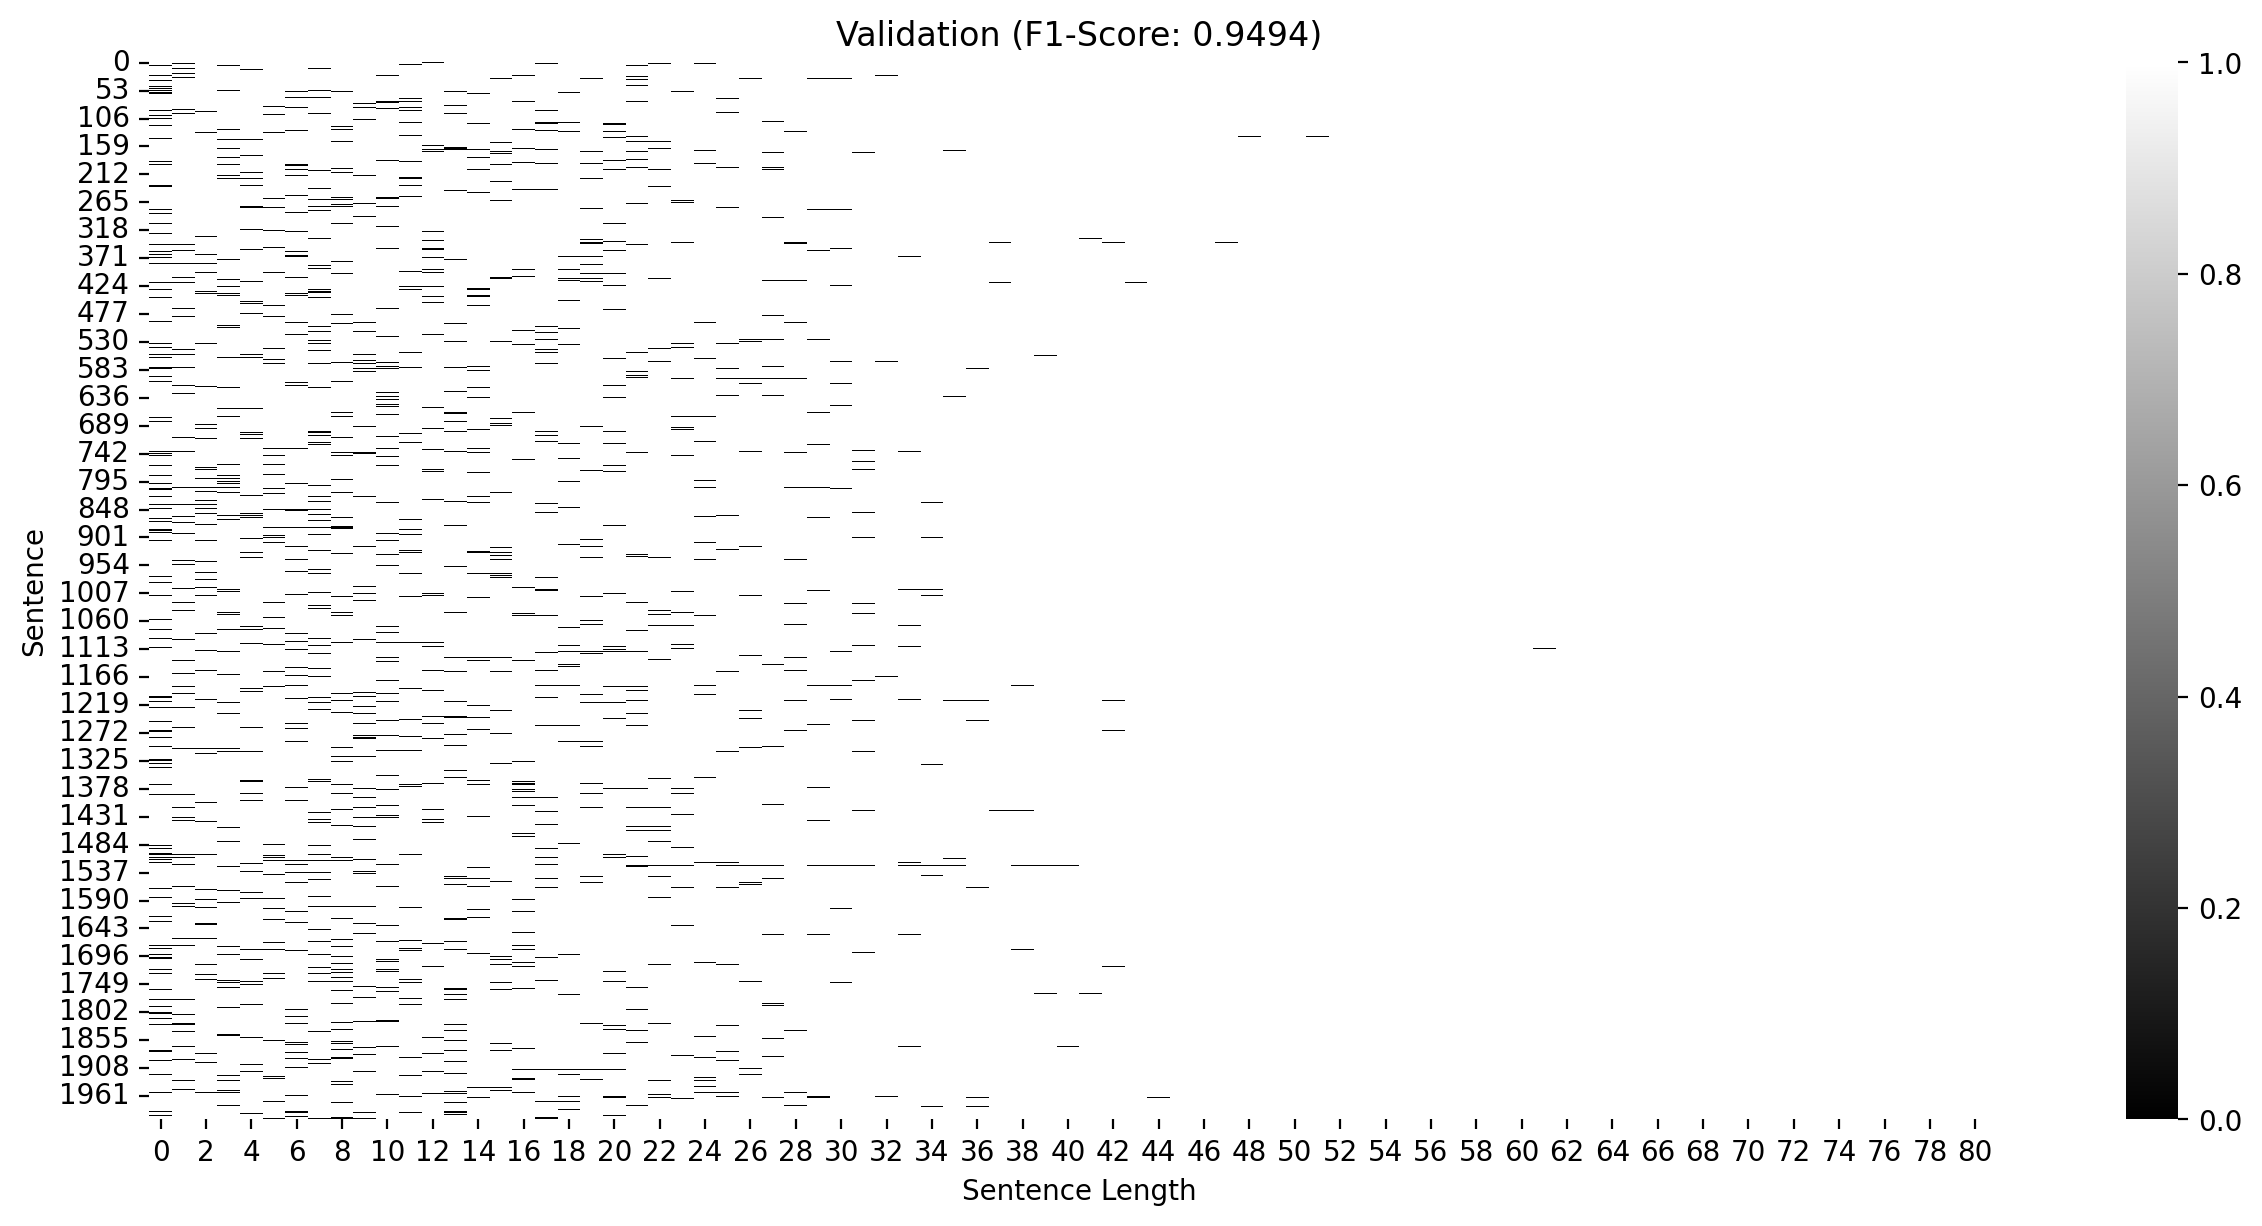

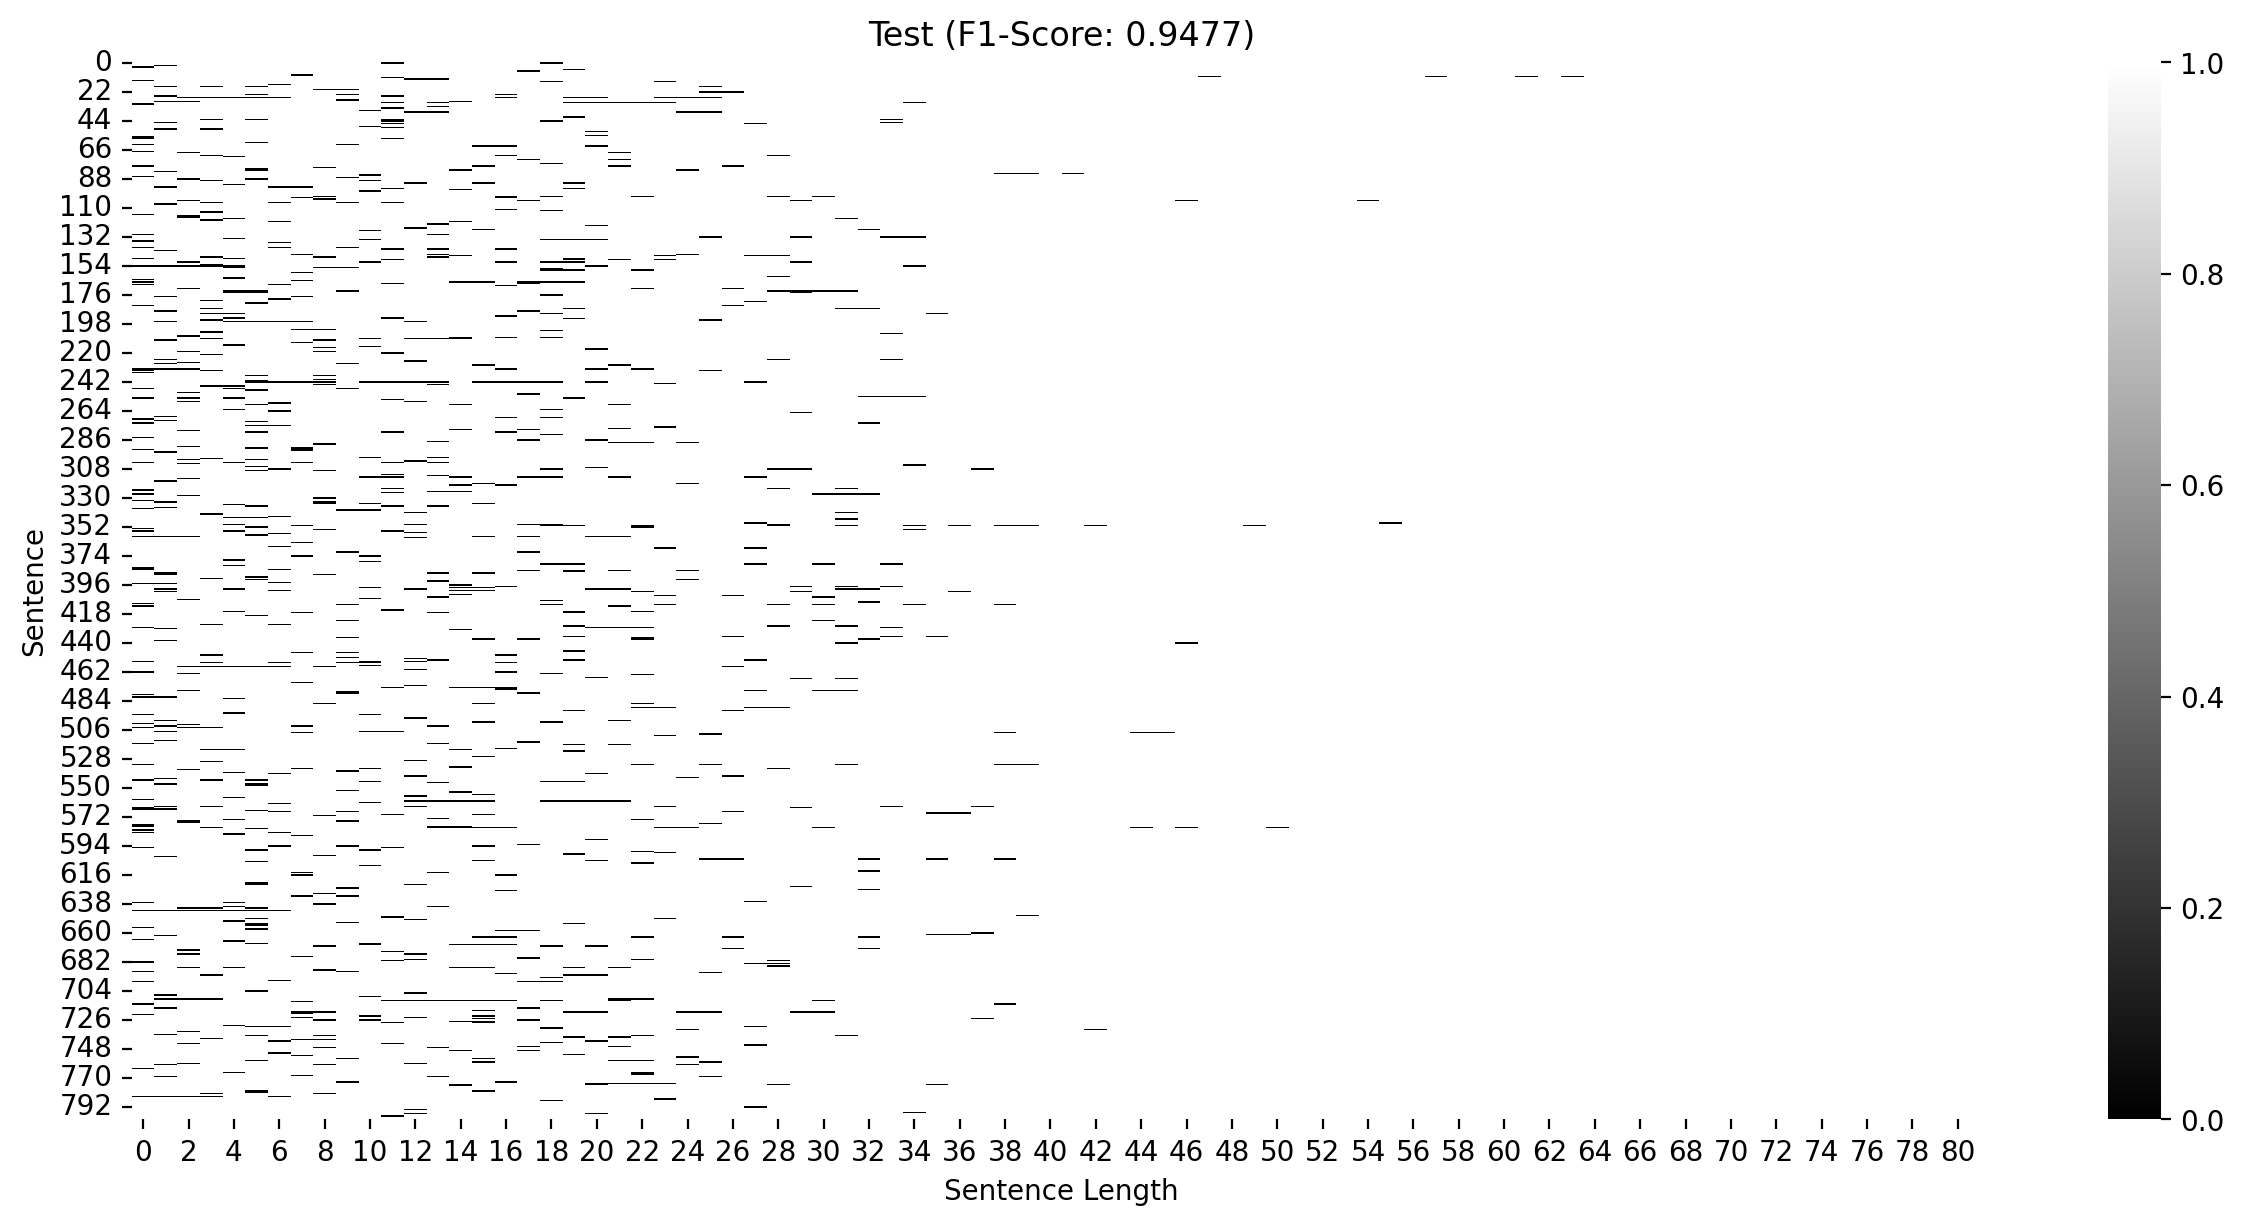

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


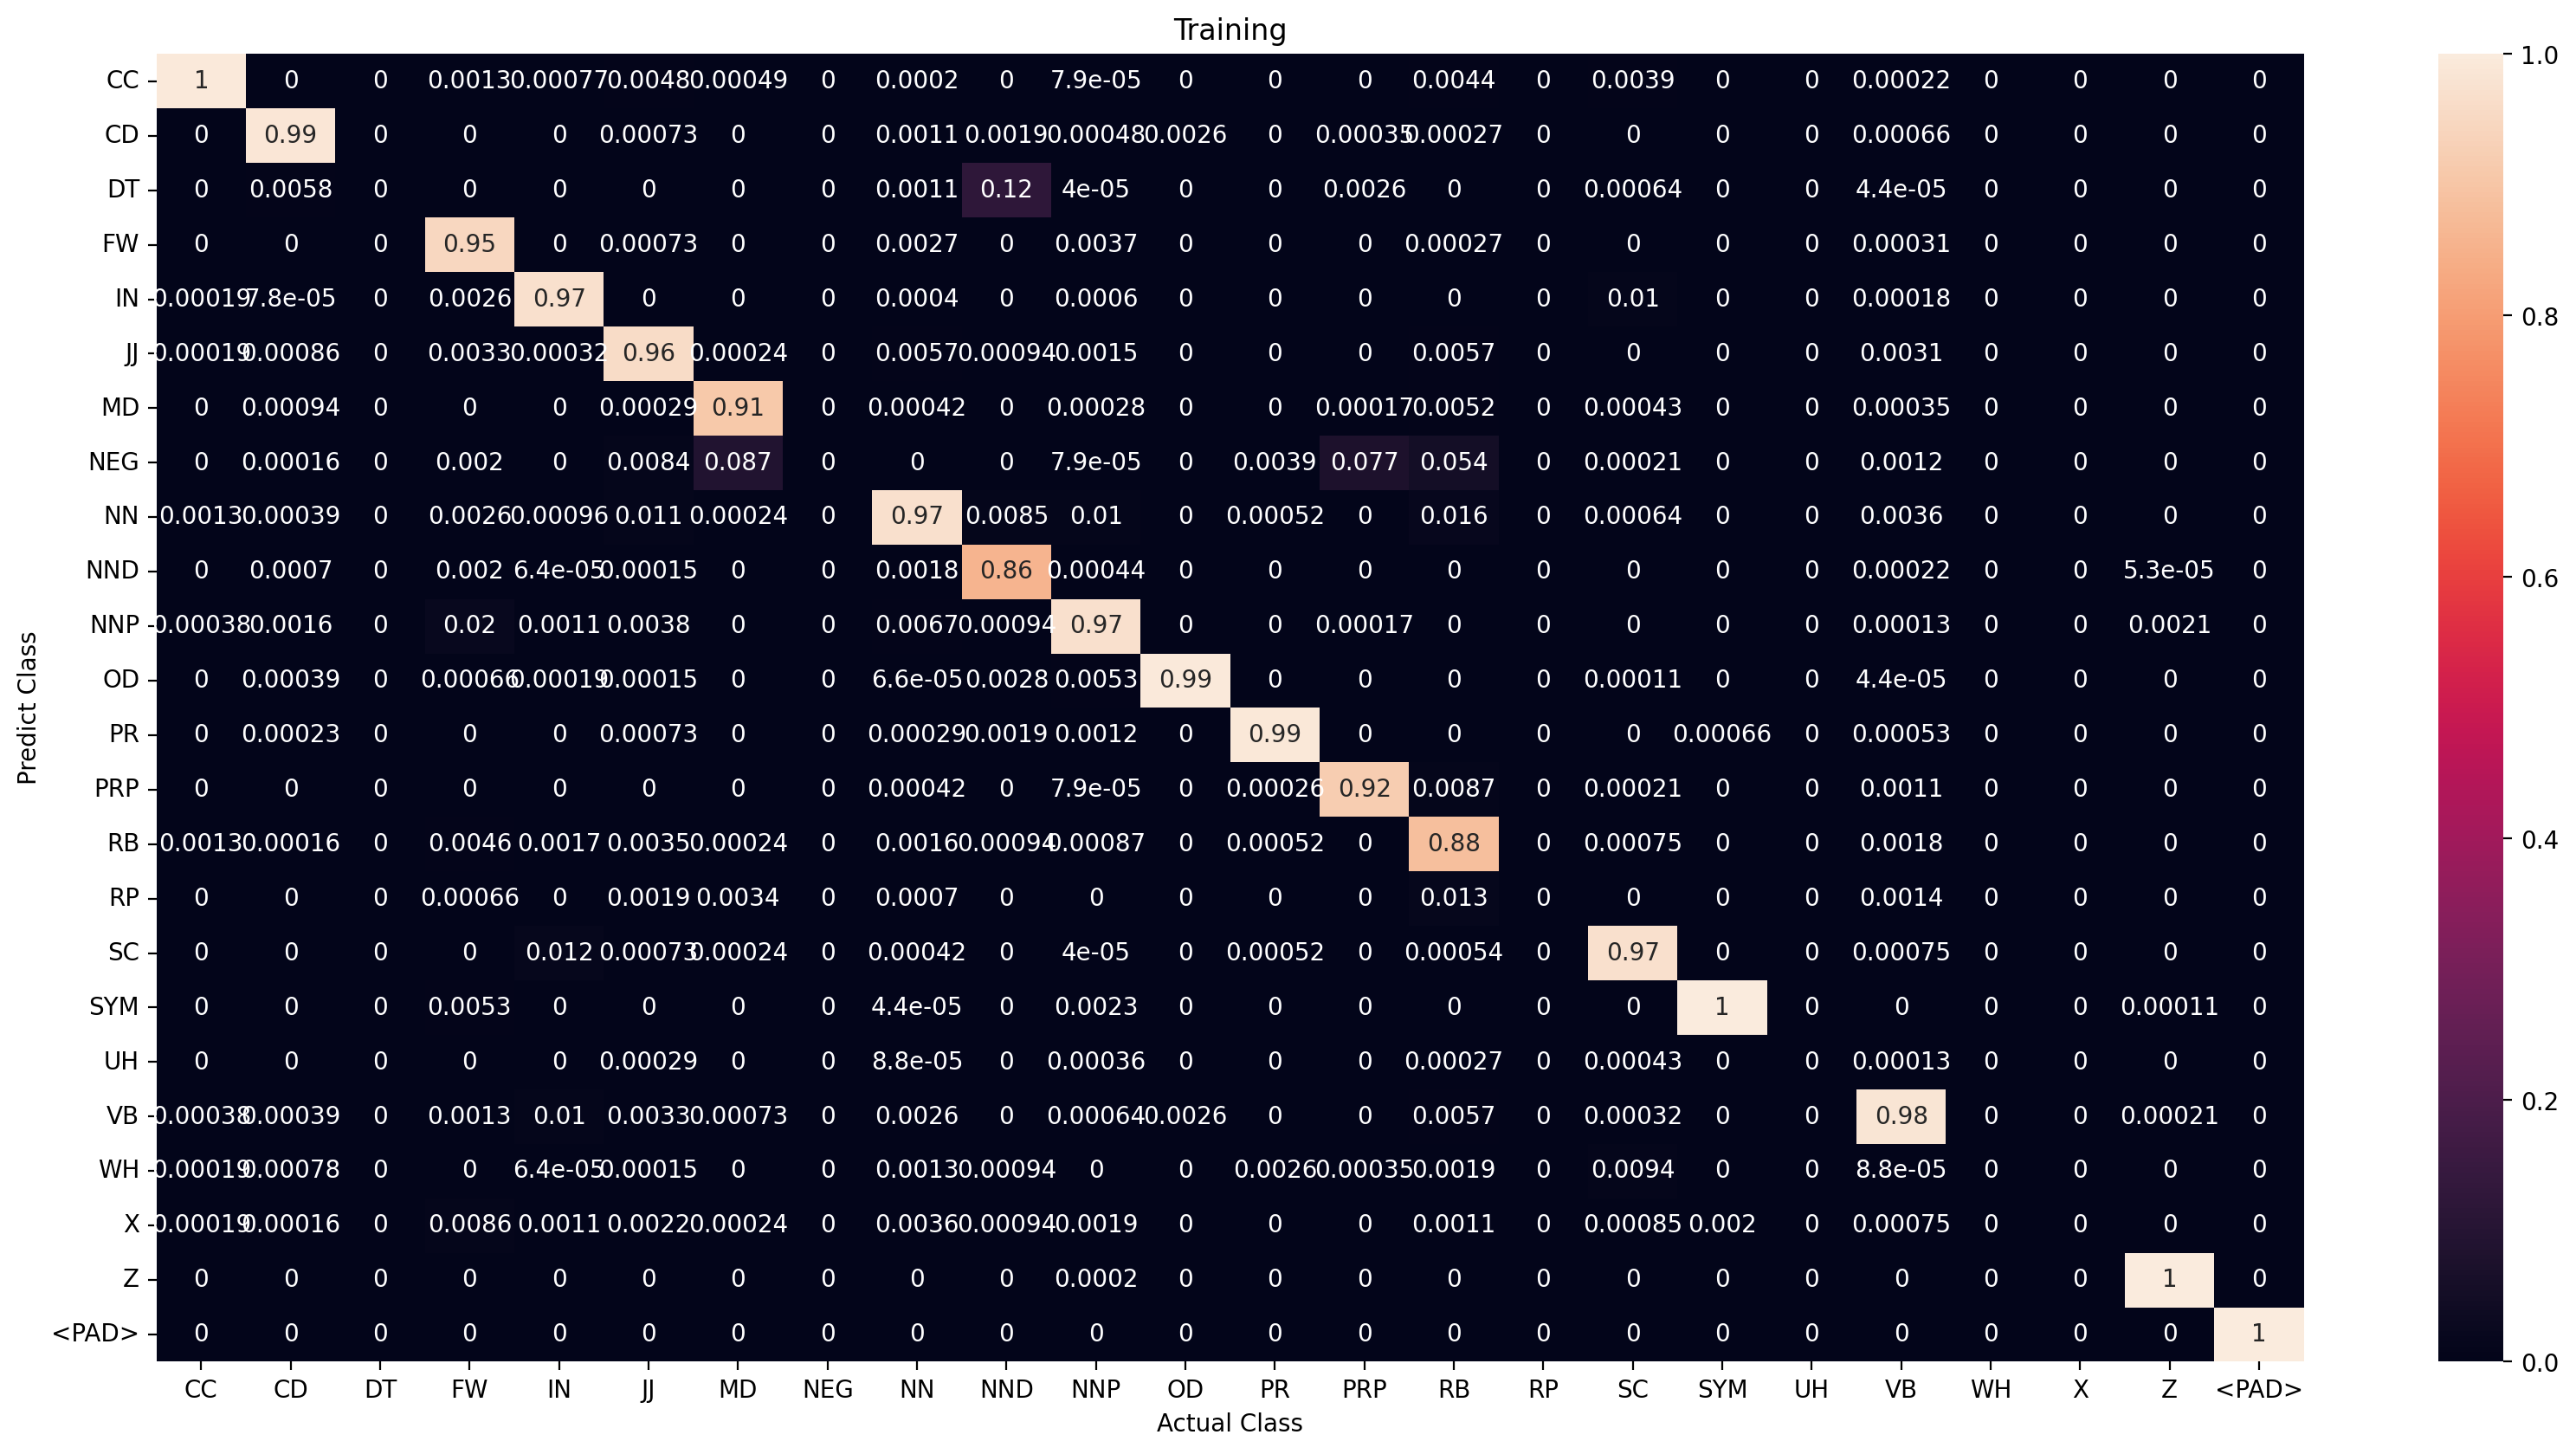

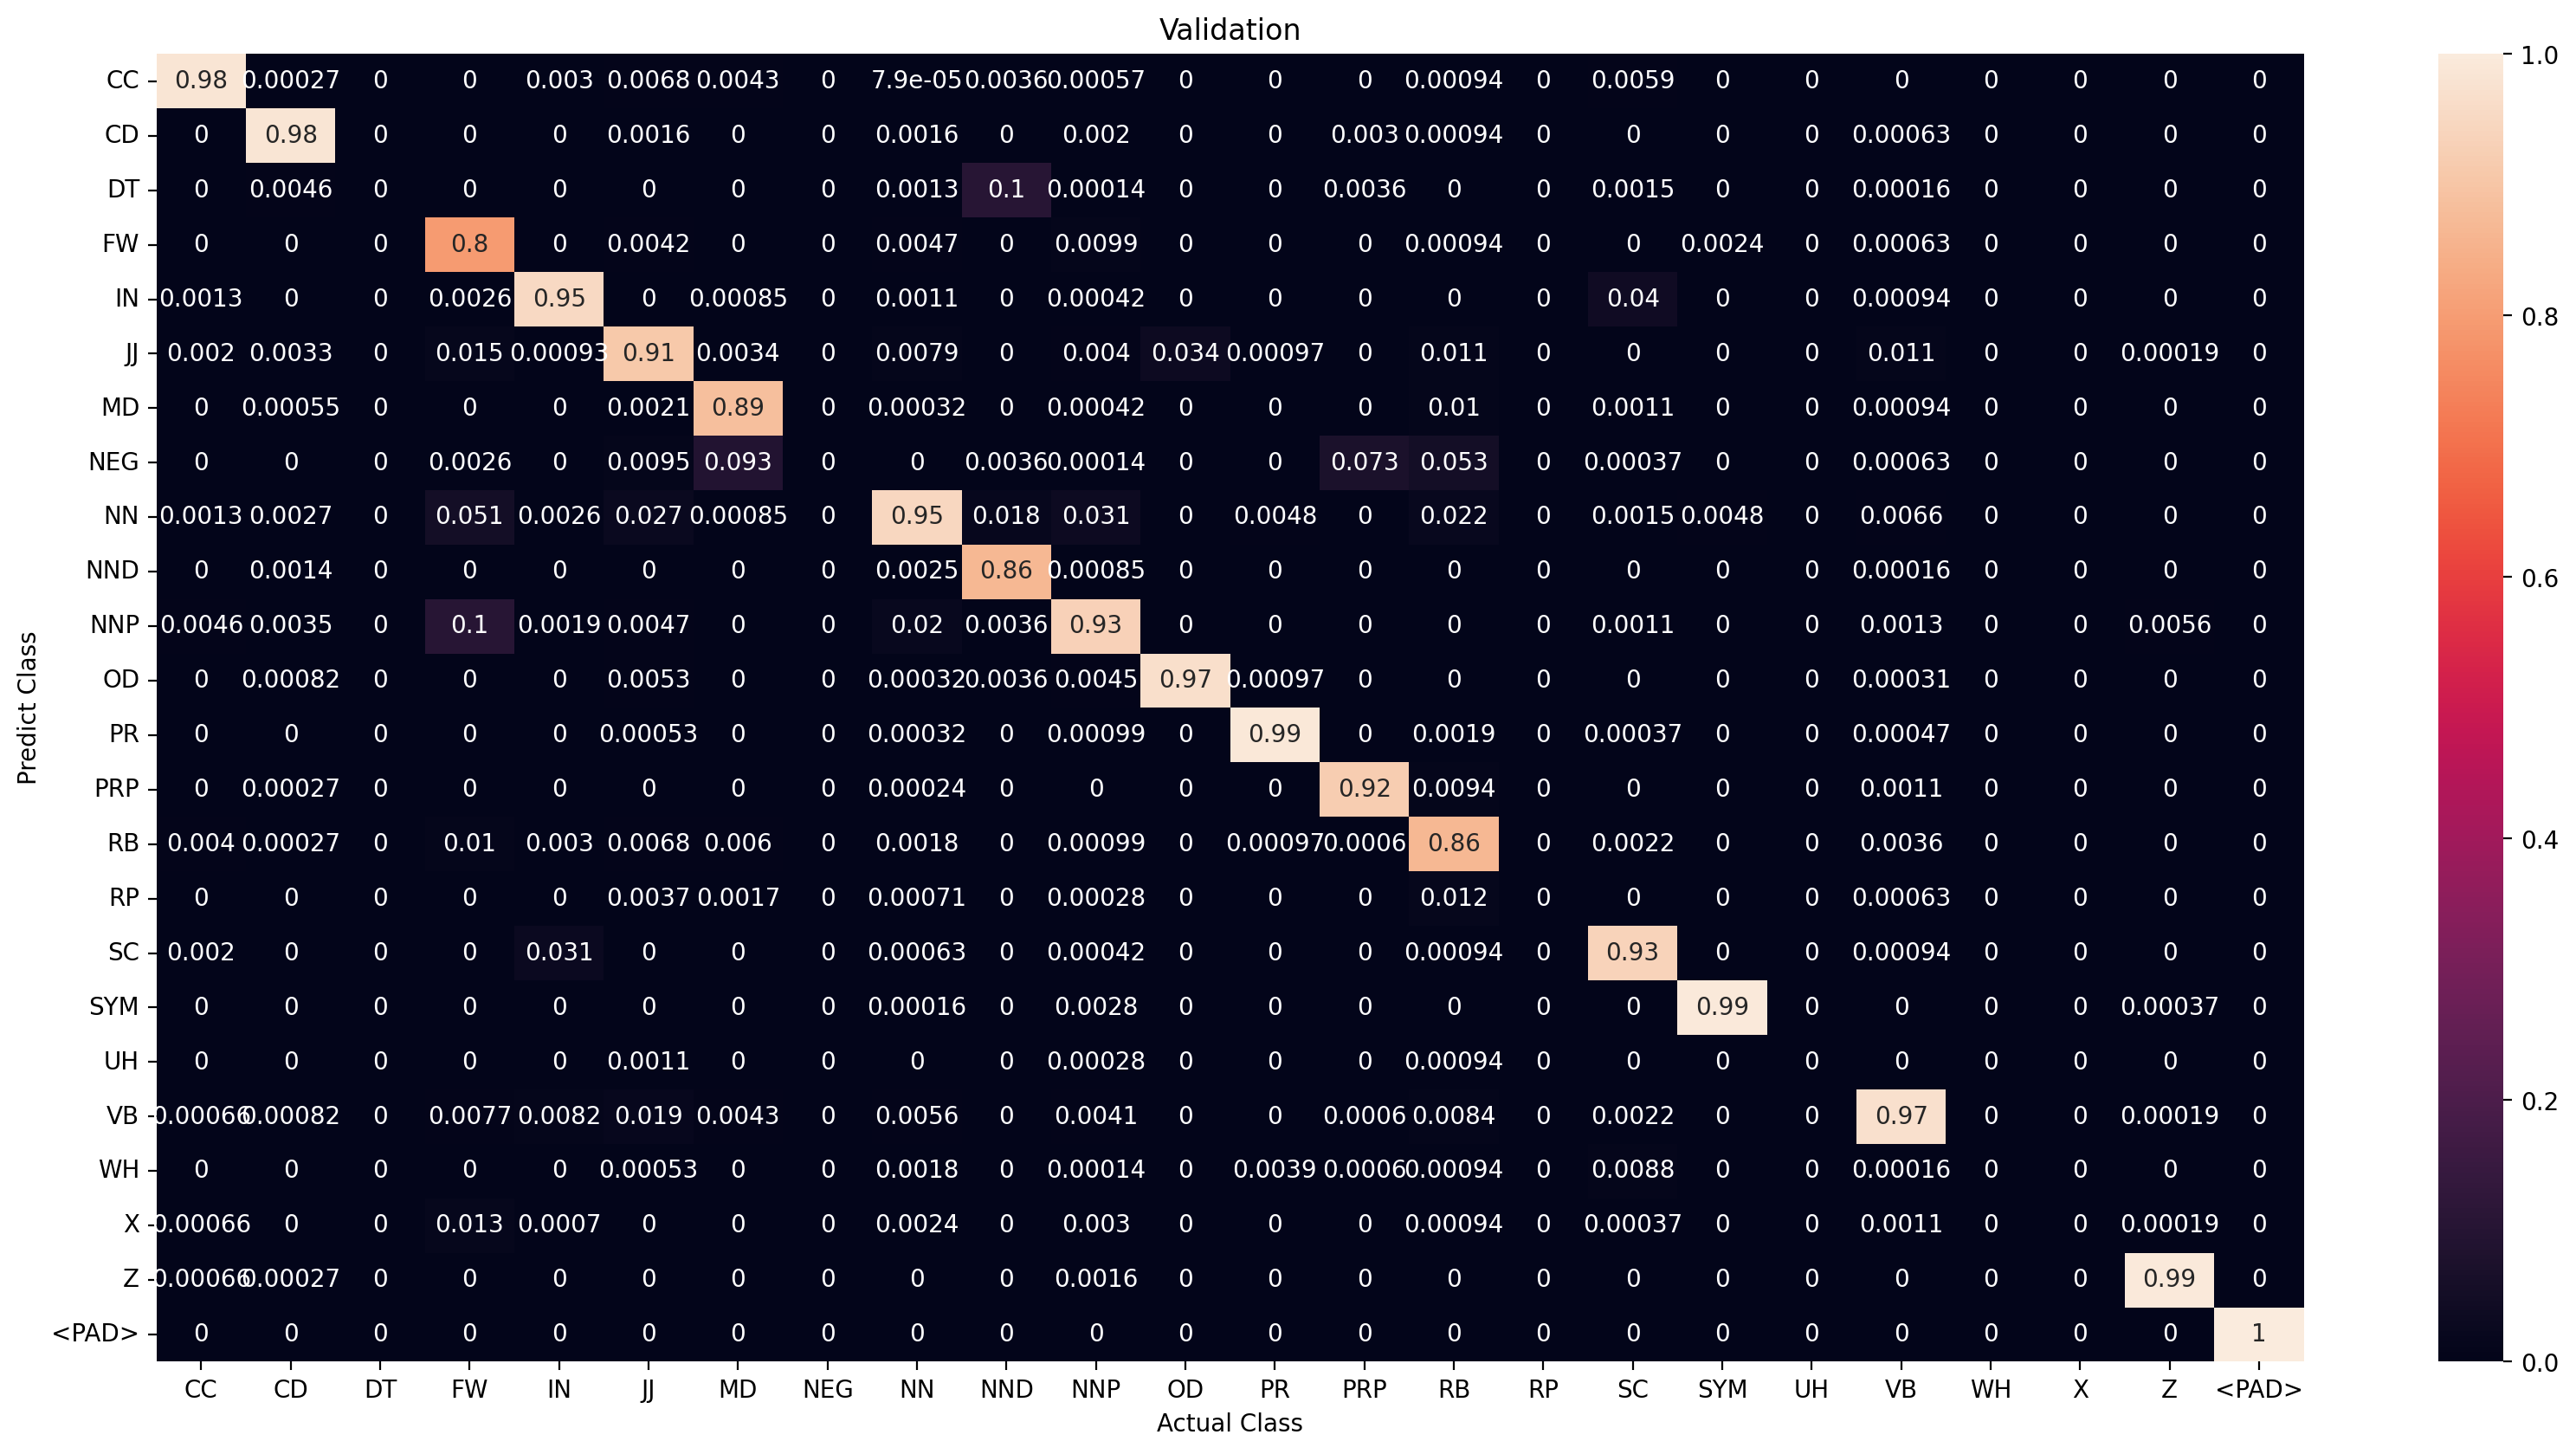

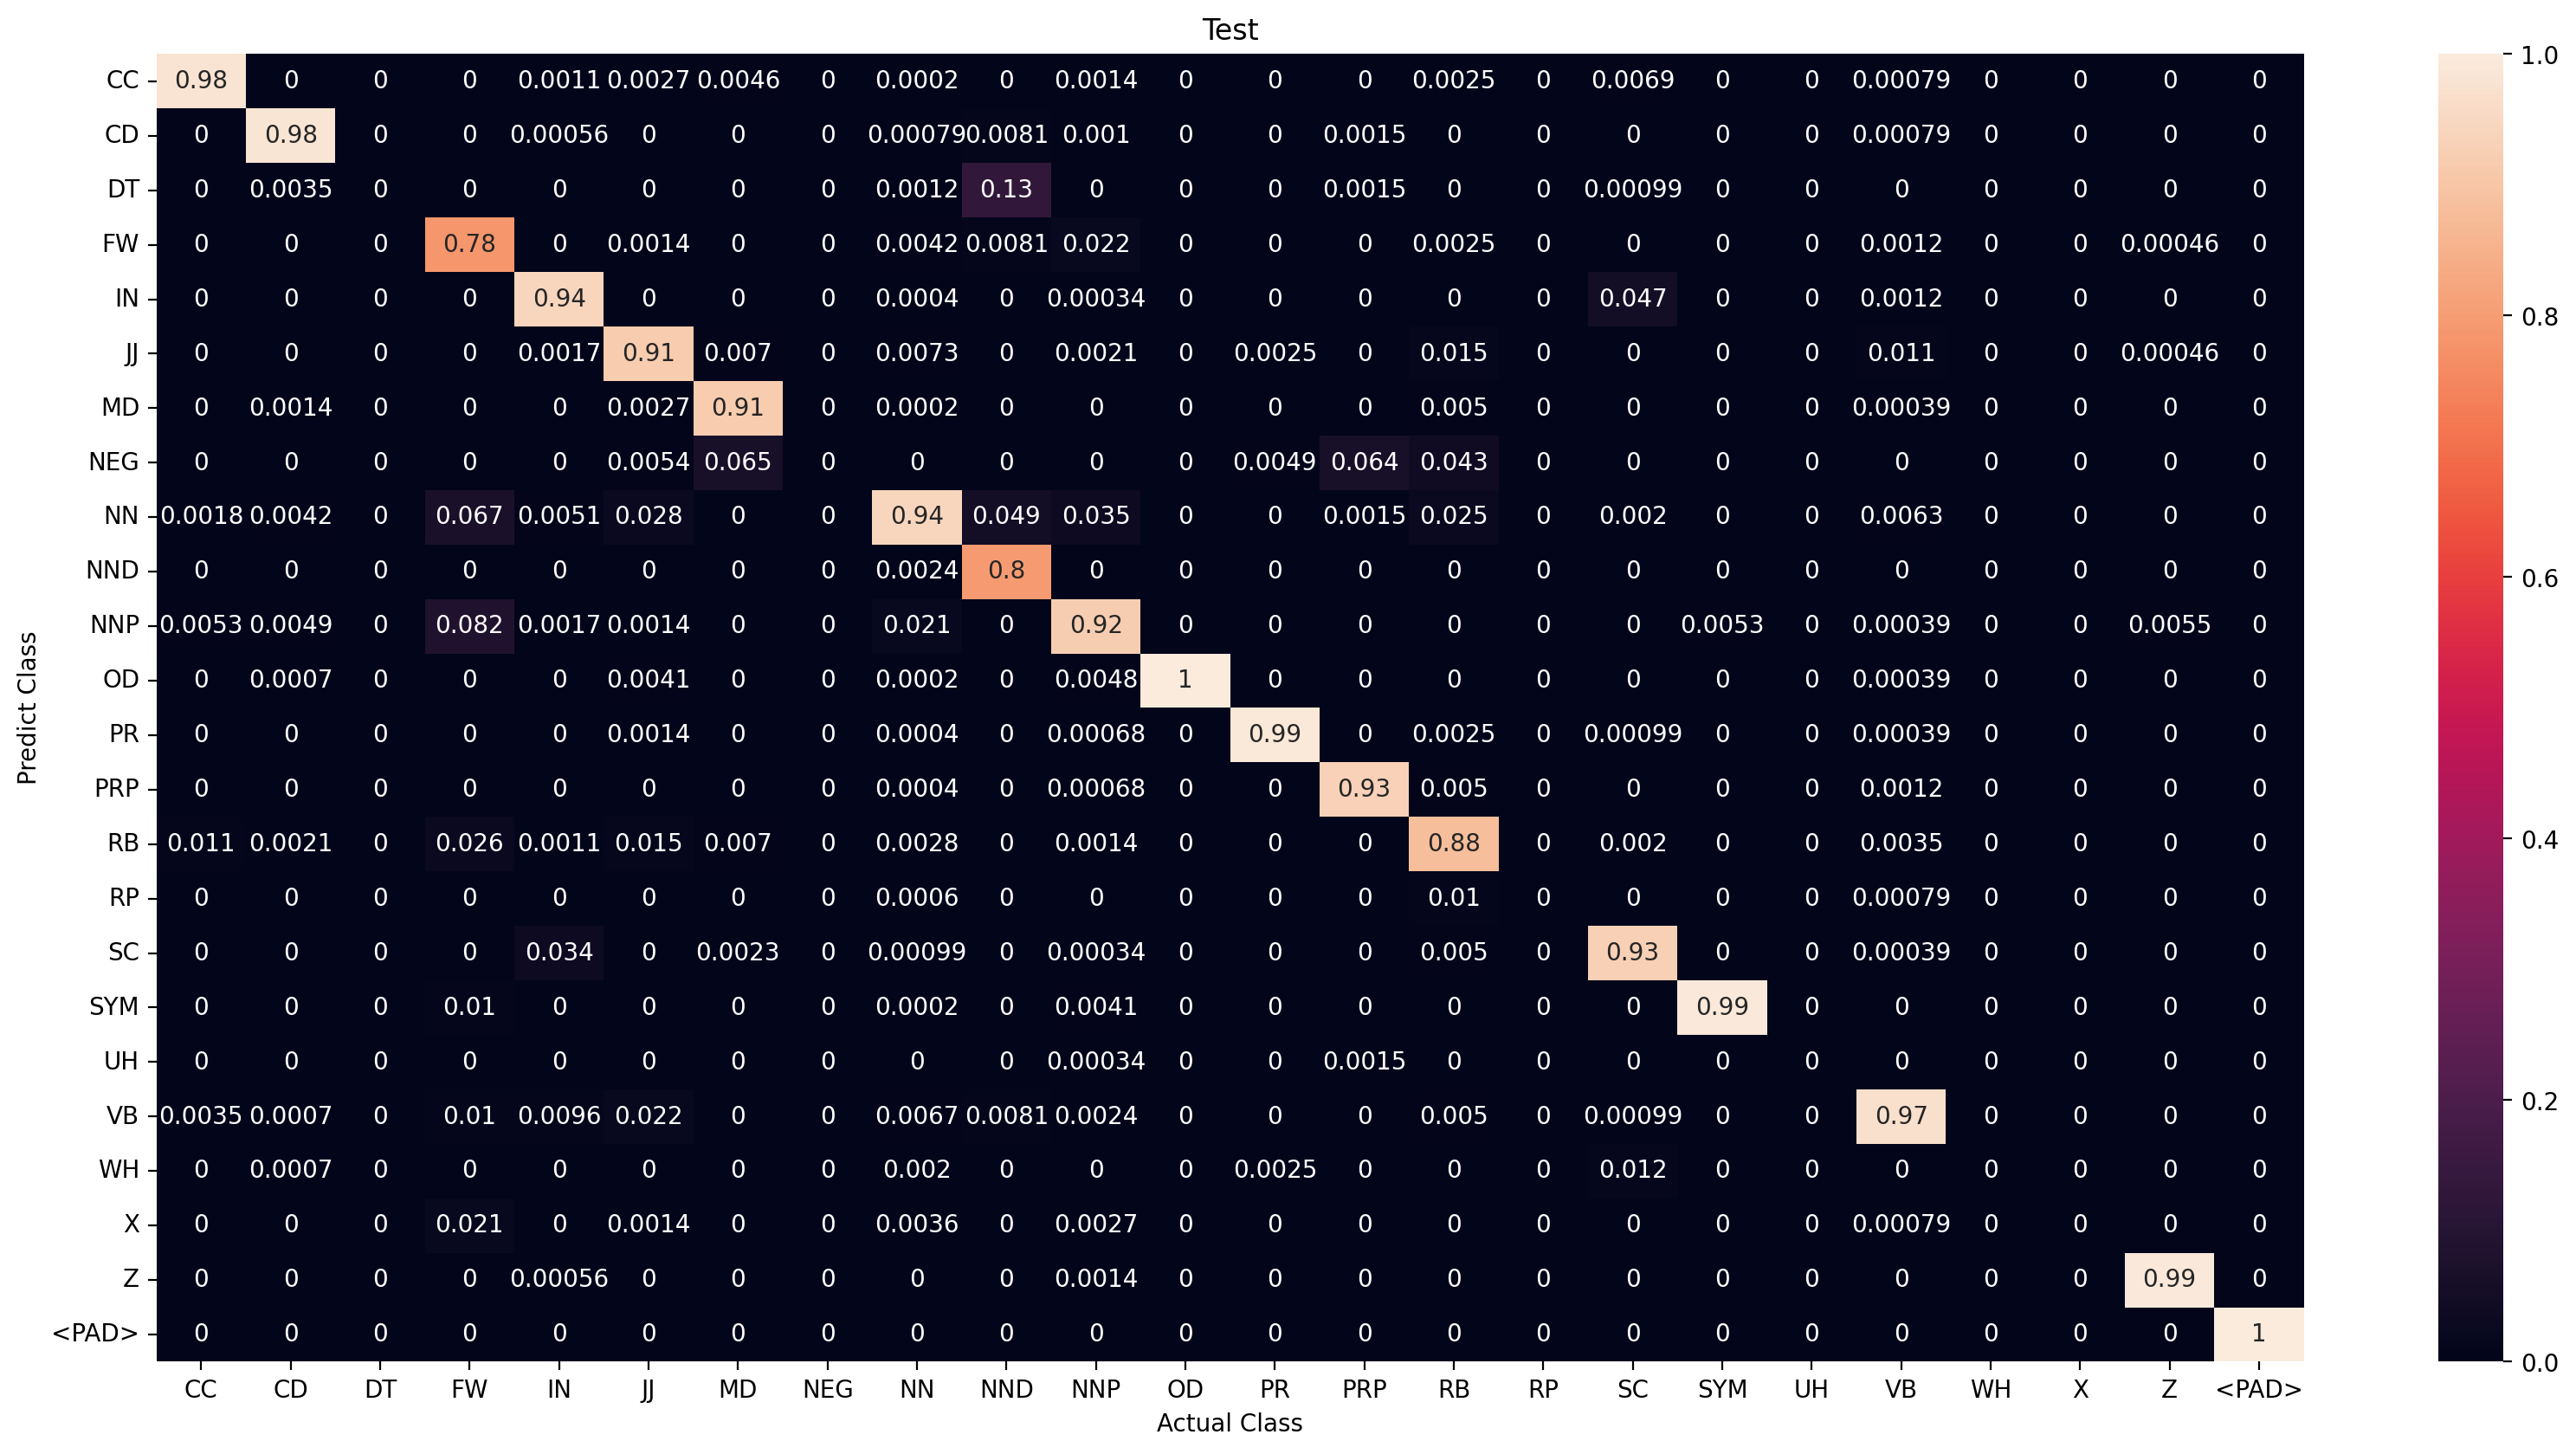

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5204       | CC    : 118      |
| CD    : 12758  | CD    : 12671      | CD    : 87       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1435       | FW    : 231      |
| IN    : 15371  | IN    : 15234      | IN    : 137      |
| JJ    : 6997   | JJ    : 6585       | JJ    : 412      |
| MD    : 3774   | MD    : 3702       | MD    : 72       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44150      | NN    : 522      |
| NND   : 1021   | NND   : 908        | NND   : 113      |
| NNP   : 24845  | NNP   : 24400      | NNP   : 445      |
| OD    : 541    | OD    : 390        | OD    : 151      |
| PR    : 3896   | PR    : 3831       | PR    : 65       |
| PRP   : 5408   | PRP   : 5328       | PRP   : 80       |
| RB    : 3463   | RB    : 3249       | RB    : 214      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 10953
Wrong prediction            : 868
Percentage correct oov pred : 92.6571356061247

Validation
Number OOV token            : 3350
Correct prediction          : 2945
Wrong prediction            : 405
Percentage correct oov pred : 87.91044776119404

Test
Number OOV token            : 1391
Correct prediction          : 1235
Wrong prediction            : 156
Percentage correct oov pred : 88.78504672897196



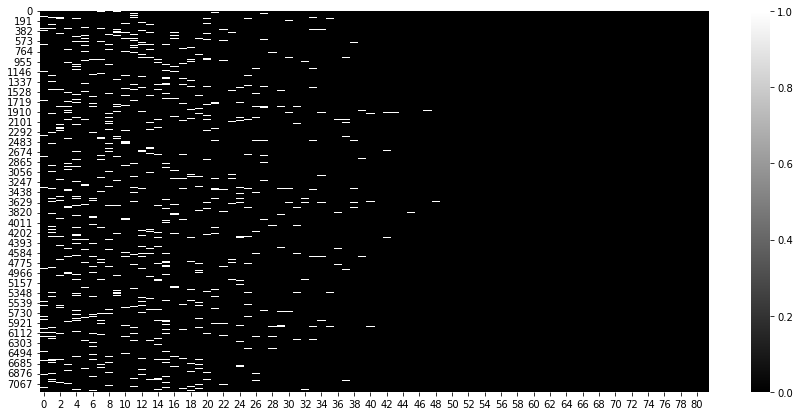

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

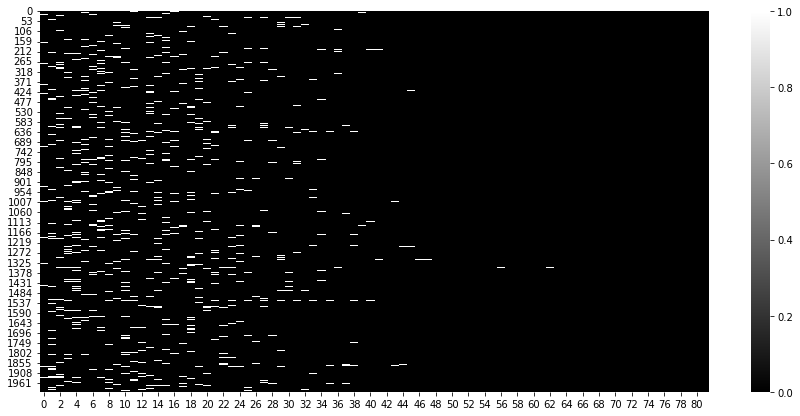

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

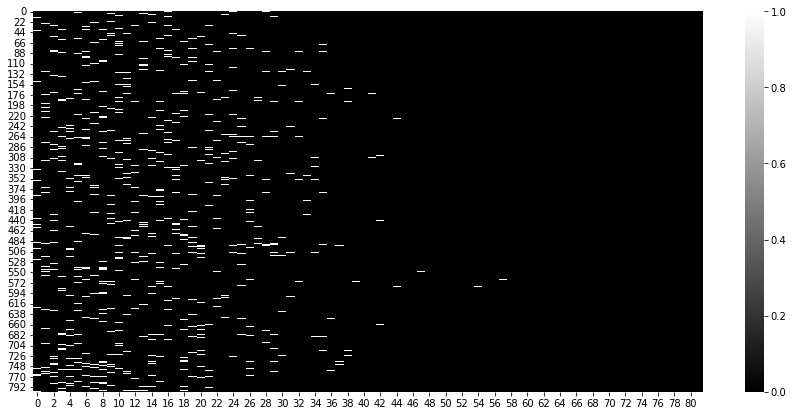

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);